In [1]:
%matplotlib notebook
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import io
import zipfile
import json
import math
import os
from osgeo import ogr

plt.ion() # make the plotting interactive

# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]

    tmc = ccrs.TransverseMercator(sbllx, sblly)
    x0, x1, y0, y1 = ax.get_extent(tmc)
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    plt.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=tmc)
    plt.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=tmc)
    plt.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=tmc)

    plt.text(sbx, sby-4500, '20 km', transform=tmc, fontsize=8)
    plt.text(sbx-12500, sby-4500, '10 km', transform=tmc, fontsize=8)
    plt.text(sbx-24500, sby-4500, '0 km', transform=tmc, fontsize=8)

# load the outline of Northern Ireland for a backdrop
outline = gpd.read_file('data/NI_outline.shp')

In [2]:
# upload data
roads = gpd.read_file('data/NI_roads.shp') 
counties = gpd.read_file('data/Counties.shp')
hospitals = gpd.read_file('data/emergency_care_hospitals.shp')
municipalities = gpd.read_file('data/Municipalities.shp')

In [3]:
# check coordinate reference system of each dataset
print(roads.crs) 
print(counties.crs)
print(hospitals.crs)
print(municipalities.crs)

epsg:4326
epsg:32629
epsg:29902
epsg:32632


In [4]:
# change reference systems to ITM epsg 2157
roads_itm = roads.to_crs(epsg= 2157) 
counties_itm = counties.to_crs(epsg= 2157)
hospitals_itm = hospitals.to_crs(epsg= 2157)
municipalities_itm = municipalities.to_crs(epsg= 2157)

print(roads_itm.head())

     SURVEY Road_class                                           geometry
0  20050114   MOTORWAY  LINESTRING (715821.764 861315.722, 715551.578 ...
1  20050114   MOTORWAY  LINESTRING (706902.850 860976.744, 706722.699 ...
2  20050114   MOTORWAY  LINESTRING (706580.488 860702.194, 706718.477 ...
3  20050202   MOTORWAY  LINESTRING (712092.429 904563.815, 712092.444 ...
4  20050202   MOTORWAY  LINESTRING (712027.800 904674.564, 712074.991 ...


In [5]:
for i, row in roads_itm.iterrows(): # iterate over each row in the GeoDataFrame
    roads_itm.loc[i, 'Length'] = row['geometry'].length # assign the row's geometry length to a new column, Length
    
print(roads_itm.head()) # print the updated GeoDataFrame to see the changes

     SURVEY Road_class                                           geometry  \
0  20050114   MOTORWAY  LINESTRING (715821.764 861315.722, 715551.578 ...   
1  20050114   MOTORWAY  LINESTRING (706902.850 860976.744, 706722.699 ...   
2  20050114   MOTORWAY  LINESTRING (706580.488 860702.194, 706718.477 ...   
3  20050202   MOTORWAY  LINESTRING (712092.429 904563.815, 712092.444 ...   
4  20050202   MOTORWAY  LINESTRING (712027.800 904674.564, 712074.991 ...   

       Length  
0  328.039442  
1  436.487174  
2  424.254143  
3  390.066144  
4  128.415820  


In [6]:
counties_itm #check counties geometry

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,geometry
0,6,TYRONE,3265.796622,1,"POLYGON ((639612.430 910662.582, 639617.397 91..."
1,1,ANTRIM,3097.847750,2,"MULTIPOLYGON (((732420.072 869023.990, 732419...."
2,2,ARMAGH,1327.228438,3,"POLYGON ((706593.480 863563.650, 706728.599 86..."
3,4,FERMANAGH,1850.832538,4,"POLYGON ((619759.712 873025.992, 619777.161 87..."
4,5,LONDONDERRY,2118.316853,5,"POLYGON ((684724.124 939891.235, 684724.744 93..."
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((725768.785 812618.064, 725765...."


Text(0.5, 1.0, 'Northern Ireland Counties, Ward Population, Roads and Hospitals')

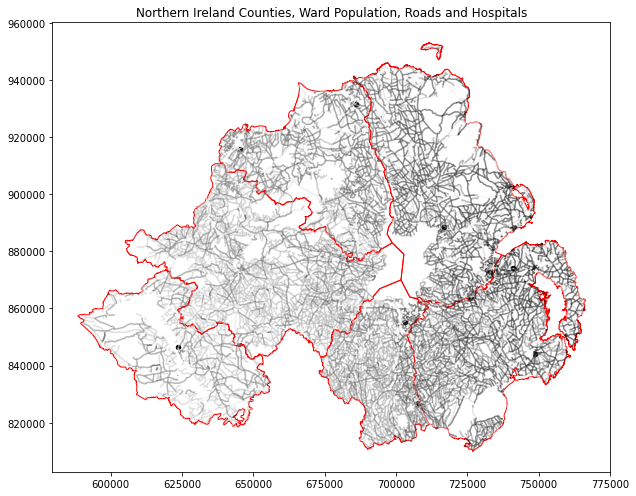

In [7]:
# initial view of hosiptal locations
fig, ax = plt.subplots(figsize=(10,10)) 

counties_itm.plot(ax=ax, edgecolor = 'r', facecolor = 'none', column = 'CountyName')
hospitals_itm.plot(ax=ax, markersize = 20, color= 'black', edgecolor = 'black')
roads_itm.plot(ax=ax, cmap='Greys', alpha=.5)

plt.title('Northern Ireland Counties, Ward Population, Roads and Hospitals')

In [8]:
# uplpad NI wards and water
wards = gpd.read_file('data/NI_Wards.shp')  
water = gpd.read_file('data/Water.shp')

In [9]:
# change coordinate system to ITM epsg 2157
wards_itm = wards.to_crs(epsg= 2157) 
water_itm = water.to_crs(epsg= 2157)

In [10]:
print(wards_itm.crs)
print(water_itm.crs)

epsg:2157
epsg:2157


In [11]:
wards_itm

,Ward Code,Ward,Population,geometry
0,95DD05,Ballykeel,1739,"POLYGON ((712347.338 902620.535, 712347.182 90..."
1,95DD06,Ballyloughan,2588,"POLYGON ((709815.265 903745.712, 709813.140 90..."
2,95DD03,Ardeevin,3503,"POLYGON ((709480.605 901295.398, 709480.917 90..."
3,95DD04,Ballee,1926,"POLYGON ((711695.814 901099.897, 711690.440 90..."
4,95DD09,Craigywarren,2590,"POLYGON ((712375.667 906822.910, 712367.762 90..."
...,...,...,...,...
577,95YY01,Beragh,2508,"POLYGON ((655602.027 868940.750, 655609.244 86..."
578,95YY02,Camowen,2283,"POLYGON ((647481.142 873035.130, 647480.236 87..."
579,95OO20,Moygashel,2189,"POLYGON ((681686.310 859616.340, 681682.342 85..."
580,95OO21,Mullaghmore,2351,"POLYGON ((679485.266 862161.428, 679480.330 86..."


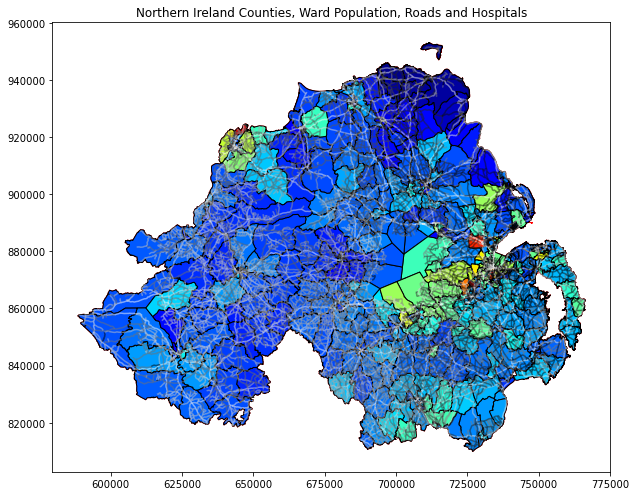

<Figure size 432x288 with 0 Axes>

In [12]:
# plot wards showing population
wards_itm.plot(ax=ax, cmap= 'jet', edgecolor= 'black', column= 'Population') 

fig

Text(0.5, 1.0, 'Northern Ireland Ward Population, Roads and Hospitals')

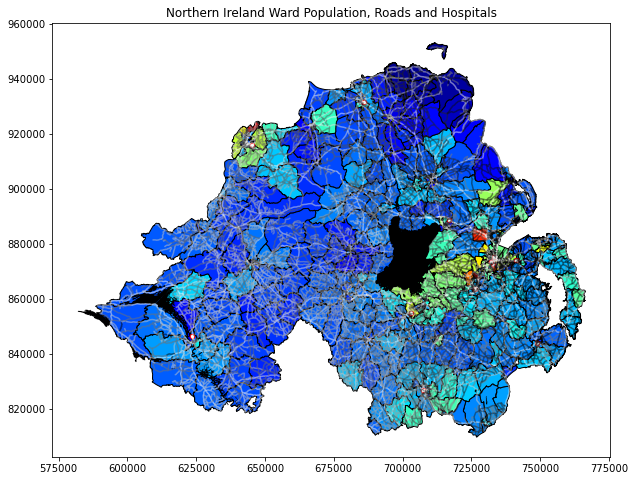

In [13]:
# plot ward population with hospital locations
fig, ax = plt.subplots(figsize=(10,10)) 

wards_itm.plot(ax=ax, cmap= 'jet', edgecolor= 'black', column= 'Population')
water_itm.plot(ax=ax, color= 'black')
roads_itm.plot(ax=ax, cmap='Greys', alpha=.5)
hospitals_itm.plot(ax=ax, markersize = 20, edgecolor= 'red', color= 'white')

plt.title('Northern Ireland Ward Population, Roads and Hospitals')

In [14]:
wards = gpd.read_file('data/NI_Wards.shp')
wards_itm = wards.to_crs(epsg= 2157)

In [15]:
centroid = wards_itm['geometry'].centroid # produce a centroid for each ward

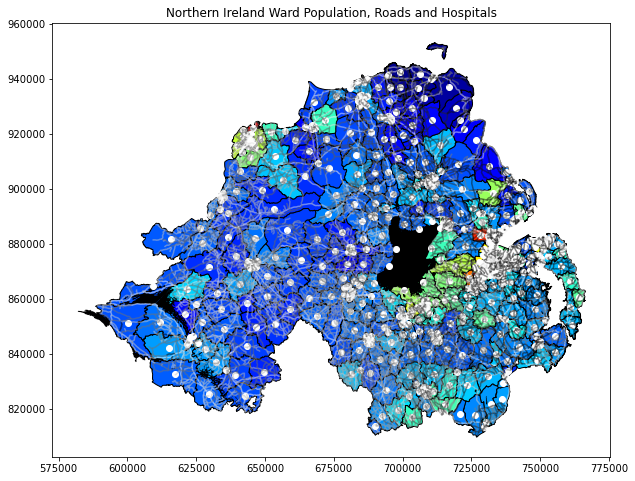

<Figure size 432x288 with 0 Axes>

In [16]:
centroid.plot(ax = ax, color= 'white') # plot the ward centroids

fig

In [17]:
centroid

type(centroid) # centroid is  geoseries 

geopandas.geoseries.GeoSeries

In [18]:
centroid.to_file("centroid.shp") # save/convert to geodatabase

In [19]:
centroids = gpd.read_file('centroid.shp')

In [20]:
type(centroids)

geopandas.geodataframe.GeoDataFrame

In [21]:
centroids

,FID,geometry
0,0,POINT (712036.682 902753.166)
1,1,POINT (709451.109 904430.729)
2,2,POINT (709181.125 901482.950)
3,3,POINT (711326.033 901621.974)
4,4,POINT (708286.653 909943.184)
...,...,...
577,577,POINT (650617.425 868478.763)
578,578,POINT (646698.568 873037.480)
579,579,POINT (680464.207 860299.762)
580,580,POINT (678809.818 863917.341)


In [22]:
wards_centroid = gpd.sjoin(centroids, wards_itm, how="inner", op='within') # spatial join wards and centroids
wards_centroid

,FID,geometry,index_right,Ward Code,Ward,Population
0,0,POINT (712036.682 902753.166),0,95DD05,Ballykeel,1739
1,1,POINT (709451.109 904430.729),1,95DD06,Ballyloughan,2588
2,2,POINT (709181.125 901482.950),2,95DD03,Ardeevin,3503
3,3,POINT (711326.033 901621.974),3,95DD04,Ballee,1926
4,4,POINT (708286.653 909943.184),4,95DD09,Craigywarren,2590
...,...,...,...,...,...,...
577,577,POINT (650617.425 868478.763),577,95YY01,Beragh,2508
578,578,POINT (646698.568 873037.480),578,95YY02,Camowen,2283
579,579,POINT (680464.207 860299.762),579,95OO20,Moygashel,2189
580,580,POINT (678809.818 863917.341),580,95OO21,Mullaghmore,2351


In [23]:
type(wards_centroid)

geopandas.geodataframe.GeoDataFrame

In [24]:
wards_centroid.to_file("ward_cent.shp")

<ipython-input-24-882b7205fee0>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  wards_centroid.to_file("ward_cent.shp")


In [25]:
buffer_20km = hospitals_itm['geometry'].buffer(distance = 20000) # create a 20km/20000m buffer around each hospital
buffer_20km.plot

<bound method GeoSeries.plot of 0     POLYGON ((752822.018 872876.367, 752725.712 87...
1     POLYGON ((753073.977 875356.831, 752977.671 87...
2     POLYGON ((751961.207 873487.240, 751864.901 87...
3     POLYGON ((752170.162 873640.206, 752073.857 87...
4     POLYGON ((706039.411 931634.954, 705943.105 92...
5     POLYGON ((736835.547 888724.037, 736739.241 88...
6     POLYGON ((768931.394 844148.472, 768835.088 84...
7     POLYGON ((746467.338 863585.403, 746371.032 86...
8     POLYGON ((761118.237 874108.057, 761021.931 87...
9     POLYGON ((723214.304 855172.339, 723117.998 85...
10    POLYGON ((727593.210 826958.396, 727496.905 82...
11    POLYGON ((665351.094 915905.559, 665254.789 91...
12    POLYGON ((643511.432 846521.627, 643415.127 84...
dtype: geometry>

Text(0.5, 1.0, 'Northern Ireland Ward Centroids and Hospitals with 20km buffer')

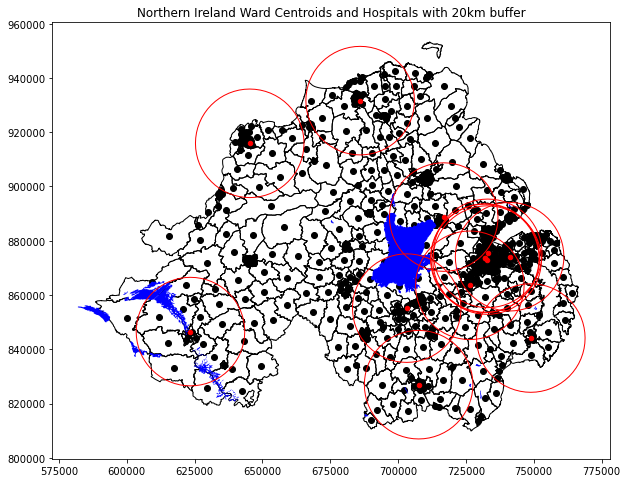

In [26]:
# plot hospitals with 20km buffer and wards with ward centroids
fig2, ax1 = plt.subplots(figsize=(10,10)) 

wards_itm.plot(ax=ax1, color= 'none', edgecolor= 'black')
wards_centroid.plot(ax=ax1, color= 'black')
water_itm.plot(ax=ax1, color= 'blue')
buffer_20km.plot(ax=ax1, color= 'none', edgecolor= 'red')
hospitals_itm.plot(ax=ax1, markersize = 20, color= 'red')

plt.title('Northern Ireland Ward Centroids and Hospitals with 20km buffer')

In [27]:
buffer_20km.to_file("buffer20.shp") # save buffer geoseries and reupload as a geodatabase

In [28]:
buffer20 = gpd.read_file("buffer20.shp")

In [29]:
buffer20

,FID,geometry
0,0,"POLYGON ((752822.018 872876.367, 752725.712 87..."
1,1,"POLYGON ((753073.977 875356.831, 752977.671 87..."
2,2,"POLYGON ((751961.207 873487.240, 751864.901 87..."
3,3,"POLYGON ((752170.162 873640.206, 752073.857 87..."
4,4,"POLYGON ((706039.411 931634.954, 705943.105 92..."
5,5,"POLYGON ((736835.547 888724.037, 736739.241 88..."
6,6,"POLYGON ((768931.394 844148.472, 768835.088 84..."
7,7,"POLYGON ((746467.338 863585.403, 746371.032 86..."
8,8,"POLYGON ((761118.237 874108.057, 761021.931 87..."
9,9,"POLYGON ((723214.304 855172.339, 723117.998 85..."


In [30]:
ward_cent = gpd.read_file('ward_cent.shp')

In [31]:
buff_ward = gpd.sjoin(ward_cent, buffer20, how = 'inner', op = 'intersects') # spatial join of wards inside buffers

In [32]:
buff_ward

,FID_left,index_righ,Ward Code,Ward,Population,geometry,index_right,FID_right
0,0,0,95DD05,Ballykeel,1739,POINT (712036.682 902753.166),5,5
1,1,1,95DD06,Ballyloughan,2588,POINT (709451.109 904430.729),5,5
2,2,2,95DD03,Ardeevin,3503,POINT (709181.125 901482.950),5,5
3,3,3,95DD04,Ballee,1926,POINT (711326.033 901621.974),5,5
5,5,5,95DD07,Broughshane,3363,POINT (713840.954 906556.842),5,5
...,...,...,...,...,...,...,...,...
316,317,317,95PP12,Florence Court and Kinawley,2630,POINT (617481.948 832927.307),12,12
317,318,318,95PP13,Irvinestown,2588,POINT (624919.375 858404.498),12,12
321,322,322,95PP11,Erne,2627,POINT (624003.570 846493.101),12,12
483,484,484,95YY21,Trillick,2440,POINT (633949.020 856514.500),12,12


In [33]:
buffer_overlapped = buffer20[buffer20["FID"].isin([0, 1, 2, 3, 5, 6, 7, 8, 9, 10])] #seprate buffers which overlap (Belfast/Greater Belfast)

In [34]:
buffer_overlapped

,FID,geometry
0,0,"POLYGON ((752822.018 872876.367, 752725.712 87..."
1,1,"POLYGON ((753073.977 875356.831, 752977.671 87..."
2,2,"POLYGON ((751961.207 873487.240, 751864.901 87..."
3,3,"POLYGON ((752170.162 873640.206, 752073.857 87..."
5,5,"POLYGON ((736835.547 888724.037, 736739.241 88..."
6,6,"POLYGON ((768931.394 844148.472, 768835.088 84..."
7,7,"POLYGON ((746467.338 863585.403, 746371.032 86..."
8,8,"POLYGON ((761118.237 874108.057, 761021.931 87..."
9,9,"POLYGON ((723214.304 855172.339, 723117.998 85..."
10,10,"POLYGON ((727593.210 826958.396, 727496.905 82..."


In [35]:
buffer_overlap_join = buffer_overlapped.geometry.unary_union #join overlapping buffers to produce one polygon

In [36]:
inside_overlap = ward_cent[ward_cent.geometry.within(buffer_overlap_join)] # show ward centroids inside overlapping buffer zone

inside_overlap

,FID,index_righ,Ward Code,Ward,Population,geometry
0,0,0,95DD05,Ballykeel,1739,POINT (712036.682 902753.166)
1,1,1,95DD06,Ballyloughan,2588,POINT (709451.109 904430.729)
2,2,2,95DD03,Ardeevin,3503,POINT (709181.125 901482.950)
3,3,3,95DD04,Ballee,1926,POINT (711326.033 901621.974)
5,5,5,95DD07,Broughshane,3363,POINT (713840.954 906556.842)
...,...,...,...,...,...,...
557,558,558,95HH10,Knockagh,2489,POINT (736971.409 886289.216)
558,559,559,95HH11,Love Lane,1417,POINT (741361.309 888557.284)
560,561,561,95OO17,Killyman,2724,POINT (688356.190 861116.277)
564,565,565,95OO19,Moy,3009,POINT (685112.015 858772.287)


In [37]:
# show ward centroids inside three remaining separate buffers
buffer_Coleraine = buffer20[buffer20["FID"].isin([4])] 
buffer_LDerry = buffer20[buffer20["FID"].isin([11])]
buffer_Enniskillen = buffer20[buffer20["FID"].isin([12])]

In [38]:
# count wards inside Coleraine hospital buffer
in_Col = buffer_Coleraine.sindex.query_bulk(ward_cent.geometry, predicate= 'intersects') 
ward_cent['intersects'] = np.isin(np.arange(0, len(ward_cent)), in_Col)

ward_cent['intersects']
ward_cent['intersects'].sum()

43

In [39]:
 # count wards inside LDerry hospital buffer
in_Lder = buffer_LDerry.sindex.query_bulk(ward_cent.geometry, predicate= 'intersects')
ward_cent['intersects'] = np.isin(np.arange(0, len(ward_cent)), in_Lder)

ward_cent['intersects'].sum()

36

In [40]:
# count wards inside the Enniskillen buffer
in_Enis = buffer_Enniskillen.sindex.query_bulk(ward_cent.geometry, predicate= 'intersects') 
ward_cent['intersects'] = np.isin(np.arange(0, len(ward_cent)), in_Enis)

ward_cent['intersects'].sum()

19

In [41]:
# count of wards inside all 20k buffers
wards_in_20 = buffer20.sindex.query_bulk(ward_cent.geometry, predicate = 'intersects') 
ward_cent['intersects'] = np.isin(np.arange(0, len(ward_cent)), wards_in_20)

ward_cent['intersects'].sum()

434

In [42]:
582 - 434 # ward centroids not within 20km of an emergency care hospital

148